Alex Beyer - ENME743 - ILA5 - Linear Policy Gradients

ep 2 got reward: -0.03687828643517186 in 100 steps 
ep 4 got reward: -0.0007663472171788367 in 100 steps 
ep 6 got reward: -0.026043660905097354 in 100 steps 
ep 8 got reward: -0.019754501356337162 in 100 steps 
ep 10 got reward: -0.35160063310548967 in 100 steps 
ave reward: -10.57721523966972 
 w/stdev: 1.2167888991818803
ep 12 got reward: -0.03382165581290373 in 100 steps 
ep 14 got reward: -0.2541819198779422 in 100 steps 
ep 16 got reward: -0.03163425507422204 in 100 steps 
ep 18 got reward: -0.007102652099855167 in 100 steps 
ep 20 got reward: -0.0010033315704291114 in 100 steps 
ave reward: -10.140572384642525 
 w/stdev: 1.7455312139178716
ep 22 got reward: -0.0320192517823731 in 100 steps 
ep 24 got reward: -0.0021206248641335358 in 100 steps 
ep 26 got reward: -0.05417013541392066 in 100 steps 
ep 28 got reward: -0.01976220860223208 in 100 steps 
ep 30 got reward: -0.03532728008078188 in 100 steps 
ave reward: -10.755380517315656 
 w/stdev: 1.4791357023190028
ep 32 got reward:

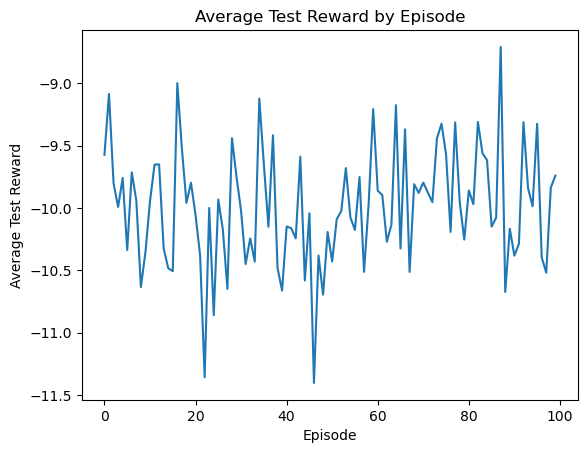

In [4]:
#Alex Beyer - ILA5 - Linear policy Gradients
#implements linear policy gradients with a gaussian potential (i think?) via a NN using the Advatage Actor-Critic (A2C) Method to apply what we talked about in class

#necessary imports
import sklearn.preprocessing
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

#boilerplate setup
device = torch.device("cpu") #i ran this via CUDA but that throws errors for unsupported cards - change "cpu" to "cuda" to reenable

#plotter class with data storage for later
class Plotter():
    def __init__(self):
        self.data = []

#actor-critic agent
class ActorCritic(nn.Module):
    def __init__(self, nStates, nActions, nHidden = 16):
        super(ActorCritic, self).__init__()
        #build NN
        self.nActions = nActions
        self.layer1 = nn.Linear(nStates, nHidden)
        self.layer2 = nn.Linear(nHidden, nHidden)
        self.layer3 = nn.Linear(nHidden, nActions)
        self.value = nn.Linear(nHidden, 1)
        self.to(device)

    #forward pass - I'm trying a different way to build this than in the NN homework where I defined everything as part of the same network; here I have the activation functions separate and directly call each layer in the activation function
    #personally I think this makes more sense but that's just how I think about the problem
    #expirimented a bit and relu for all 3 layers gives some interesting properties; namely that it seems to be able to get a positive score - this score might be entirely artificial (I'm not sure the model can even score anything higher than 1 and even that might not be physically possible)
    # but it still seems to correspond to great model preformance
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        mu = F.relu(self.layer3(x)) #try different activators
        sigma = F.softmax(self.layer3(x), dim = -1) + .0001 #offset to prevent singularities
        dist = torch.distributions.Normal(mu.view(self.nActions).data, sigma.view(self.nActions).data)
        value = self.value(x)
        return dist, value

#build the A2C trainer as a class which calls the ActorCritic agent class in itself
class A2C:
    def __init__(self, envName, gamma = .5, learnRate = .05, nEps = 100, nSteps = 100, nEpsTest = 10):
        #store all the variables we'll need later
        self.envName = envName
        self.env = gym.make(envName)
        self.model = ActorCritic(self.env.observation_space.shape[0], self.env.action_space.shape[0]).to(device)
        self.opt = optim.Adam(self.model.parameters(),learnRate)
        self.data = {"loss": []}
        self.nEps = nEps
        self.nEpsTest = nEpsTest
        self.nSteps = nSteps
        self.gamma = gamma

        #draw 10000 samples from the state space to initialize Q table
    def initStateScaler(self):
        ssSample = np.array([self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(ssSample)

    #continue to this as the model runs
    def scaleState(self, state):
        scaled = self.scaler.transform(np.array([state[0]]).reshape(1,-1))
        return scaled[0]

    #update the A2C policy
    def a2cUpdate(self, rewards, lProbs, values, state):
        qVals = []
        nextQ = 0
        pw = 0
        #apply the discount rate to the rewards found by the model, appending the total end-of-path reward to the Q table update
        for reward in rewards[::-1]:
            nextQ += self.gamma ** pw * reward
            pw += 1
            qVals.append(nextQ)
        #update Q-table, stepping through in reverse to update
        qVals = qVals[::-1]
        qVals = torch.tensor(qVals)
        qVals = (qVals - qVals.mean()) / (qVals.std() + .000001) #offset to prevent singularities
        #reset loss
        loss = 0
        for nextProb, value, nextQ in zip(lProbs, values, qVals):
            #update A2C parameters
            advantage = nextQ - value.item()
            actorLoss = -nextProb * advantage
            criticLoss = F.smooth_l1_loss(value[0], nextQ)
            loss += criticLoss + actorLoss

        self.opt.zero_grad()
        loss.min().backward()  
        self.opt.step()

        #pass the current state into the actor-critic NN model to find the optimal next action  
    def getNextAction(self, state):
        if type(state) is tuple:
            dist, value = self.model(torch.Tensor(state[0].reshape(1,-1))) 
        else:
            dist, value = self.model(torch.Tensor(state)) 
        action = dist.sample().numpy()
        nextProb = dist.log_prob(torch.FloatTensor(action))
        return action, nextProb, value

    #also define a test function to be callled immediately after training, in which we...
    def test(self, nEps, tEp):
        testReward = []
        #for each testing episode...
        for e in range(self.nEpsTest):
            #reinitialize our environment...
            state = self.env.reset()
            nextReward = []
            #and for each iteration of the testing episode...
            for t in range(self.nSteps):
                #run the same logic as the training step, but without updating parameters, brekaing when the car has reached the goal...
                action, _, _ = self.getNextAction(state)
                _, reward, truncated, terminated, _ = self.env.step(action)
                nextReward.append(reward)
                if truncated or terminated:
                    break
                #and appending the reward to a list for return <-- this is what im plotting
            testReward.append(sum(nextReward))
        return np.mean(testReward), np.std(testReward)

    #setup train loop
    def train(self):
        #initialize storage and zero score
        score = 0.0
        rewards = []
        muRewards = []
        sigmaRewards = []
        #setup initial Q-table
        self.initStateScaler()
        #for each episode...
        for e in range(self.nEps):
            #initialize empty storage...
            state = self.env.reset()
            score = 0.0
            stepNum = 0
            rewards = []
            lProbs = []
            values = []
            #then for each training run in the episode...
            for t in range(self.nSteps):
                #run the model, updating parameters and ending the episode if the model has succeeded...
                stepNum += 1
                if type(state) is tuple:
                    state = self.scaleState(state[0].reshape(1,-1))
                else:
                    state = self.scaleState(state.reshape(1,-1))
                action, nextProb, value = self.getNextAction(state)
                state, reward, truncated, terminated, _ = self.env.step(action)
                score += reward
                rewards.append(reward)
                values.append(value)
                lProbs.append(nextProb)
                if truncated or terminated:
                    break
            #appending the score to the list...
            rewards.append(score)
            #updating the actor-critic parameters...
            self.a2cUpdate(rewards, lProbs, values, state)
            #while printing progress...
            if (e+1) % 2 == 0:
                print("ep {} got reward: {} in {} steps ".format(e+1, rewards[e], stepNum))
            if (e+1) % 10 == 0:
                nextMuReward, nextSigmaReward = self.test(self.nEpsTest,e)   
                print('ave reward: {} \n w/stdev: {}'.format(nextMuReward, nextSigmaReward))
            #and saving episode mean statistics for plotting
            nextMuReward, nextSigmaReward = self.test(self.nEpsTest,e)
            muRewards.append(nextMuReward)
            sigmaRewards.append(nextSigmaReward)
        #finally, clean up
        self.env.close()
        return rewards, lProbs, values, muRewards, sigmaRewards

if __name__ == "__main__":
    A2C = A2C("MountainCarContinuous-v0")
    rewards, lProbs, values, muRewards, sigmaRewards = A2C.train()
    plt.plot(muRewards) 
    plt.xlabel("Episode")
    plt.ylabel("Average Test Reward")
    plt.title("Average Test Reward by Episode")
    plt.show()

My algorithm runs a number of training episodes on the MountainCar, then runs a smaller number of testing episodes, taking the average reward from those for datapoints on the plot. The outputs we see in text form here are stats form the training episodes while the plot is testing episode specific. The reason the graph looks like this is because it's converging on a solution within the first batch of training episodes - what we're seeing is a model preforming almost as well as it can. Because there is always some amount of random exploration going on we'll always see some amount of oscillation in the average episode reward, just from the model attempting to explore and improve it's policy. Overall the model preforms excellently.